In [2]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from naca4digit_airfoil import Naca4DigitAirfoil
from navier_stokes import NavierStokesPDEs

/Users/ggito/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 0.7

rho  = 1.0
mu   = 0.02
umax = 1.0

Set the default float type to float64


In [4]:
airfoil = Naca4DigitAirfoil(c=0.2, M=2, P=4, T=12, a=10, offset_x=0.20, offset_y=0.35)

In [5]:
# Geometry defintion
farfield = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
# airfoil_boundary = boundaryNACA4D(0, 0, 12, 0.2, 250, 0.20, 0.35)
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

inner_rec  = dde.geometry.Rectangle([0.15, 0.28], [0.28, 0.42])
outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)

inner_points = inner_dom.random_points(10000)
outer_points = outer_dom.random_points(40000)

farfield_points = farfield.random_boundary_points(1280)
airfoil_points  = airfoil.get_boundary_points(250)

points = np.append(inner_points, outer_points, axis = 0)
points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

(0.0, 1.0)

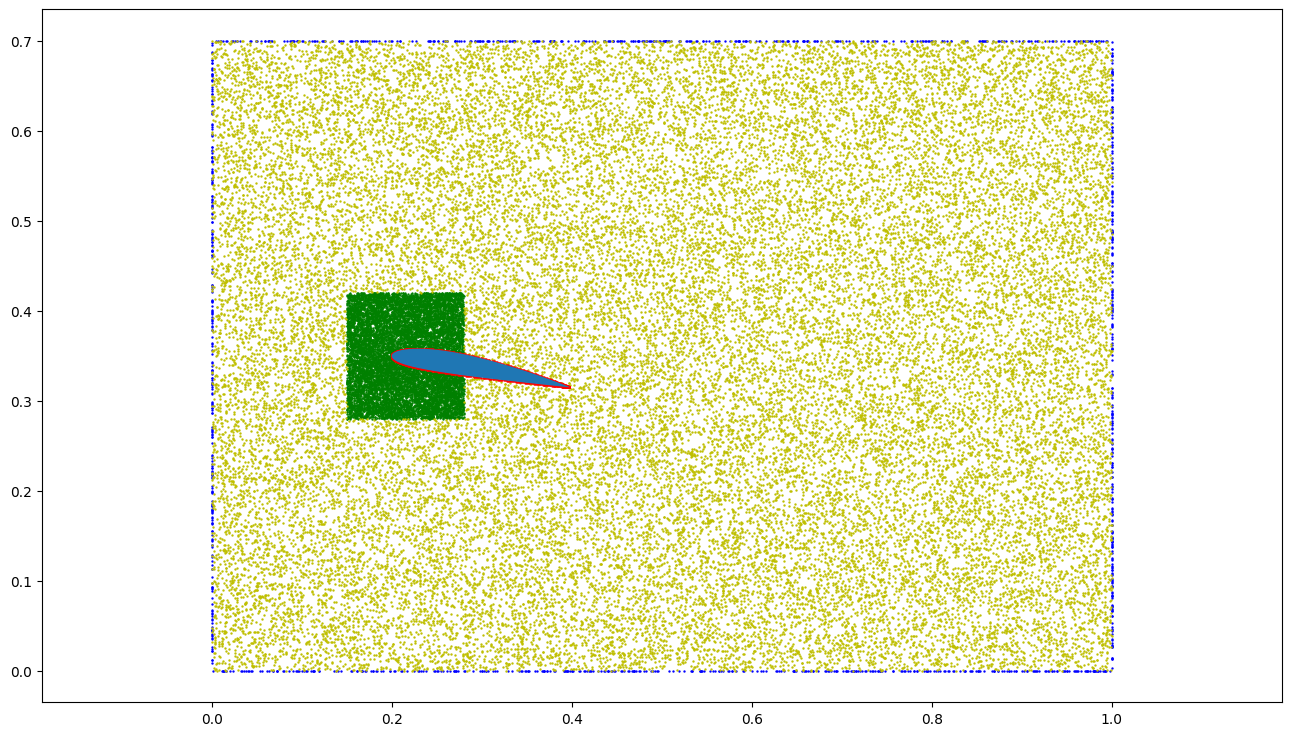

In [6]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.5, c='b')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.5, c = 'g')
plt.scatter(outer_points[:, 0], outer_points[:, 1], s = 0.5, c = 'y')
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = 'r')
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
ax1.set_xlim([xmin, xmax])

In [11]:
# Boundaries definition
def boundary_farfield_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], xmin)

def boundary_farfield_top_bottom(x, on_boundary):
    return on_boundary and (np.isclose(x[1], ymax) or np.isclose(x[1], ymin))

def boundary_farfield_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], xmax)

def boundary_airfoil(x, on_boundary):
    return on_boundary and airfoil_geom.on_boundary(np.array([x]))[0]

# Boundary values definition
def fun_u_farfield(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1) - 1.0

def fun_no_slip_u(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def fun_no_slip_v(x, y, _):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def funP(x):
    return 0.0

In [12]:
# Boundary conditions assembly   
bc_inlet_u = dde.OperatorBC(geom, fun_u_farfield, boundary_farfield_inlet)
bc_inlet_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_farfield_inlet)

bc_top_bottom_u = dde.OperatorBC(geom, fun_u_farfield, boundary_farfield_top_bottom)
bc_top_bottom_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_farfield_top_bottom)

bc_outlet_p = dde.DirichletBC(geom, funP, boundary_farfield_outlet, component = 1)

bc_airfoil_u = dde.OperatorBC(geom, fun_no_slip_u, boundary_airfoil)
bc_airfoil_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_airfoil)

bcs = [bc_inlet_u, bc_inlet_v, bc_top_bottom_u, bc_top_bottom_v, bc_outlet_p, bc_airfoil_u, bc_airfoil_v]

In [13]:
pdes = NavierStokesPDEs(rho=rho, mu=mu)

In [14]:
# Problem setup
data = dde.data.PDE(geom, pdes.get_pdes, bcs, num_domain = 0, num_boundary = 0, num_test = 5000, anchors = points)

dde.config.set_default_float('float64')

Set the default float type to float64


(-0.05, 1.05, -0.034999999999999996, 0.735)

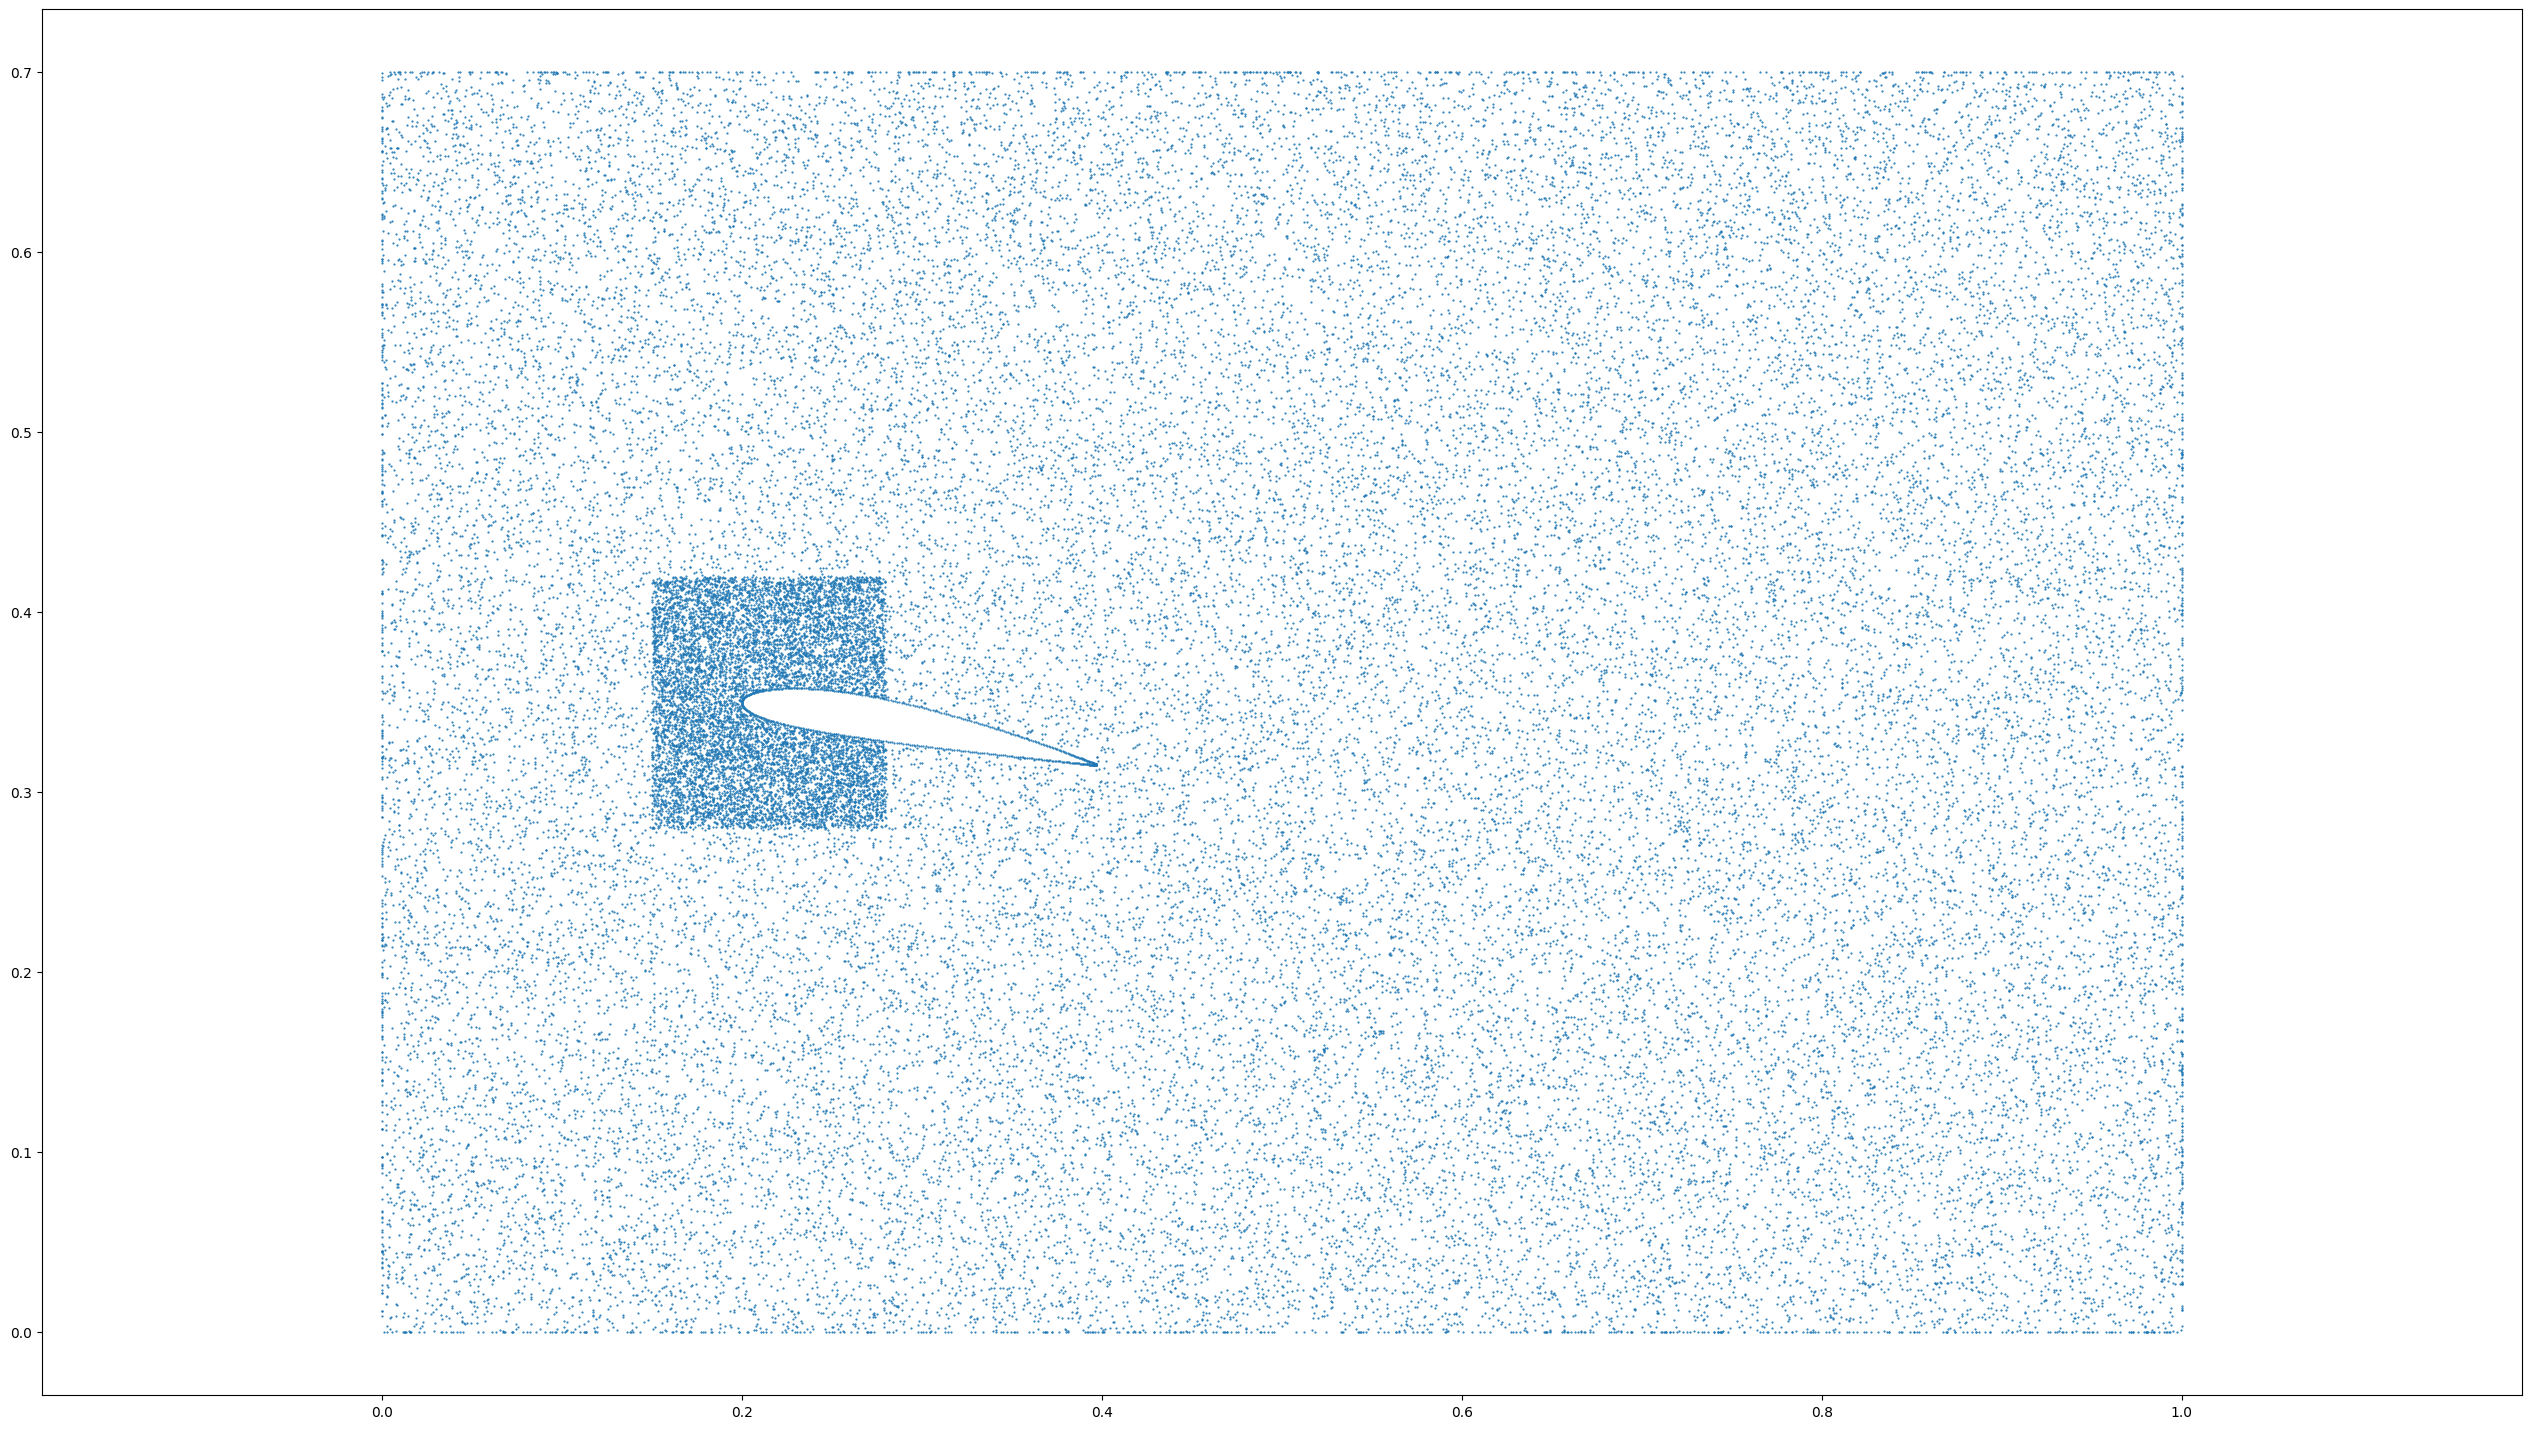

In [15]:
plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

In [16]:
# Neural network definition
layer_size  = [2] + [40] * 8 + [5]
activation  = 'tanh' 
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)

In [ ]:
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]) # Giving more weight to bcs
losshistory, train_state = model.train(epochs = 30000, display_every = 100, model_save_path = './')
dde.saveplot(losshistory, train_state, issave = True, isplot = True)

In [ ]:
# model.compile(optimizer = 'L-BFGS-B', loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
# model.train_step.optimizer_kwargs = {'options': {'maxcor': 50, 
#                                                    'ftol': 1.0 * np.finfo(float).eps, 
#                                                    'maxfun':  50000, 
#                                                    'maxiter': 50000, 
#                                                    'maxls': 50}}

In [ ]:
losshistory, train_state = model.train(display_every = 1, model_save_path = './')
dde.saveplot(losshistory, train_state, issave = True, isplot = True)

In [ ]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.01
dy = 0.01
x = np.arange(xmin, xmax + dy, dx)
y = np.arange(ymin, ymax + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [ ]:
def getU(x, y):   
    return dde.grad.jacobian(y, x, i = 0, j = 1) 

def getV(x, y): 
    return - dde.grad.jacobian(y, x, i = 0, j = 0)  

def getP(x, y):
    return y[:, 1:2]

In [ ]:
# Model predictions generation
u = model.predict(X, operator = getU)
v = model.predict(X, operator = getV)
p = model.predict(X, operator = getP)

for i in range(len(X)):
   if airfoil.inside(np.array([X[i]]))[0]:
       u[i] = 0.0
       v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

airfoil_plot = boundaryNACA4D(0, 0, 12, 0.2, 150, offset_x = 0.20, offset_y = 0.35)

fig1, ax1 = plt.subplots(figsize = (16, 9))
#ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(p.min(), 2, 0.001)
cnt1 = ax1.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig('NACA0012NS0.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
ax2.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(0, u.max(), 0.001)
cnt2 = ax2.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig('NACA0012NS1.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
ax3.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(-0.235, v.max(), 0.001)
cnt3 = ax3.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig('NACA0012NS2.png')